In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import scipy.stats as ss
from torch.distributions import Normal
import matplotlib.pylab as plt

This code implements MLE esitmation of the time-inhomogeneous OU process

In [2]:
import sys
sys.path.insert(0,'vp_class/')

from class_tou import tOU, tou_gradient

In [3]:
torch.set_default_dtype(torch.float64)

1. Simulate path from time-inhomogeneous OU process

In [4]:
alpha = torch.tensor([0.633, -0.633])
beta = torch.tensor([3.59, 3.59])
m0 = torch.tensor([1.79, 1.79])
r = torch.tensor([1.124, 1.124])
sigma = torch.tensor([1., 1.])

In [5]:
params = torch.stack([alpha, beta, m0, r, sigma]).view(-1, 2, 1)

In [6]:
alpha, beta, sigma, m0, r = params

In [7]:
sde = tOU(t0=0., t1=2., z0=0., alpha=alpha, beta=beta, sigma = sigma, m0 = m0, r=r, timegrid=False, dN=1000)

In [8]:
def m_of_t(t, params):
    t0 = t - t[:, 0].reshape(-1, 1)
    alpha, beta, r, m0, sigma = params
    
    return alpha * ( (t0 + 1) ** beta - 1 ) + m0

Plot sample path from time-inhomogenoeus OU process

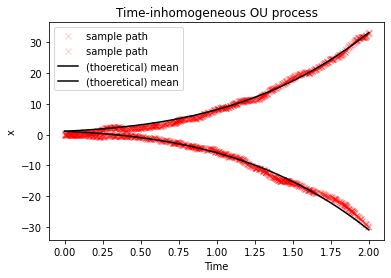

In [9]:
plt.title("Time-inhomogeneous OU process")
plt.plot(sde.pts.T, sde.trj.T, 'rx', alpha=0.2,  label='sample path')
plt.plot(sde.pts.T, m_of_t(sde.pts, params).T, color='black', label='(thoeretical) mean' )
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.show()

2. Implement Gradient Descent algorithm to find the MLE

Note that this algorithm is sensitive to initialization and prone to over-flow

In [50]:
alpha_ = torch.zeros((2, 1))
beta_ = torch.ones((2, 1)) + 0.5 
m0_ = torch.randn((2, 1))
r_ = torch.ones((2, 1))
sigma_ = torch.ones((2, 1))


learning_rate = 0.00005

for i in range(1501):
    params = torch.stack([alpha_, beta_, m0_, r_, sigma_]).view(-1, 2, 1)
    
    lr = learning_rate
    update = tou_gradient(sde.pts, sde.trj, params)
    
    alpha_ += learning_rate * update['alpha']
    m0_ += learning_rate * update['m0']
    
    beta_ += learning_rate * update['beta']
    r__  = r_ + learning_rate * update['r']
    
    while any(r__ < 0):
        for d in range(r_.shape[0]):
            if r__[d] < 0:
                while r__[d] < 0:
                    r__[d] = r_[d] + lr * update['r'][d]
                    lr *= 0.5
#             if beta__[d] < 0:
#                 while beta__[d] < 0:
#                     beta__[d] = beta_[d] + lr * update['beta'][d]
#                     lr *= 0.5
    r_ = r__
#     beta_ = beta__
    
    if i % 500 == 0:
        print('alpha = ', alpha_.data.numpy(), "beta = ", beta_.data.numpy(),
              "r = ", r_.data.numpy(), "m0 = ", m0.data.numpy(), 'LL = ', update['LL'])

alpha =  [[ 0.01386407]
 [-0.01304318]] beta =  [[1.5]
 [1.5]] r =  [[0.95280281]
 [0.95776822]] m0 =  [[1.124]
 [1.124]] LL =  tensor([-223.5079, -134.9375])
alpha =  [[ 1.11012082]
 [-1.22871454]] beta =  [[3.10920308]
 [3.02863705]] r =  [[2.69970834]
 [6.42381794]] m0 =  [[1.124]
 [1.124]] LL =  tensor([899.1023, 757.2090])
alpha =  [[ 0.90484738]
 [-1.07456056]] beta =  [[3.29865596]
 [3.13708477]] r =  [[2.67422459]
 [5.93987209]] m0 =  [[1.124]
 [1.124]] LL =  tensor([902.9350, 832.0536])
alpha =  [[ 0.8435828 ]
 [-0.98852224]] beta =  [[3.36352655]
 [3.2013713 ]] r =  [[2.66745306]
 [5.67021544]] m0 =  [[1.124]
 [1.124]] LL =  tensor([903.3256, 853.9885])


In [51]:
print("True alpha = \n", alpha.data.numpy(), "\nAlpha_MLE = \n", alpha_.data.numpy(), "\nTrue Beta = \n", beta.data.numpy(), "\nBeta_MLE = \n", beta_.data.numpy()
     , "\nTrue r = \n", r.data.numpy(), "\nr_MLE = \n", r_.data.numpy(), "\nTrue m0 = \n", m0.data.numpy(), "\nm0_MLE = \n", m0_.data.numpy())

True alpha = 
 [[ 0.633]
 [-0.633]] 
Alpha_MLE = 
 [[ 0.8435828 ]
 [-0.98852224]] 
True Beta = 
 [[3.59]
 [3.59]] 
Beta_MLE = 
 [[3.36352655]
 [3.2013713 ]] 
True r = 
 [[1.]
 [1.]] 
r_MLE = 
 [[2.66745306]
 [5.67021544]] 
True m0 = 
 [[1.124]
 [1.124]] 
m0_MLE = 
 [[0.11877011]
 [1.71854509]]


Plot the observations and samples drawn from the process with MLE estimator.

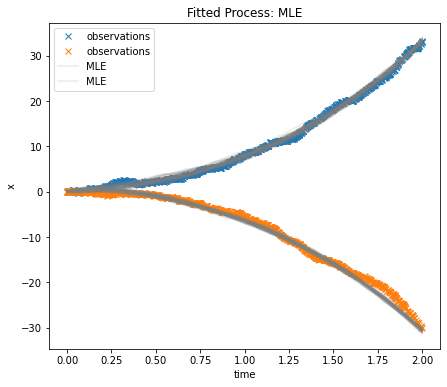

In [52]:
plt.figure(figsize=(7,6))
plt.title("Fitted Process: MLE")
plt.plot(sde.pts.T, sde.trj.T, 'x', label='observations')
for i in range(50):
    vi_ = tOU(0., 2., 0., *torch.stack([alpha_, beta_, m0_, r_, sigma_]).view(-1, 2, 1), dN=100)
    plt.plot(vi_.pts.T, vi_.trj.T, alpha=0.15, color='grey')
    if i == 49:
        plt.plot(vi_.pts.T, vi_.trj.T, alpha=0.15, color='grey', label='MLE')
plt.xlabel("time")
plt.ylabel("x")
plt.legend()
plt.show()